## A/B–тестирование

В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. Проанализируем итоги эксперимента и сделаем вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### Предобработаем данные!

Импортируем необходимые библиотеки для работы с данными

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from io import StringIO
import re
import requests
import scipy
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from urllib.parse import urlencode
import timeit
import time
%matplotlib inline

Для начала выгрузим наши дата сеты и проведем базовую проверку на количество строк, количество пропусков и на типы данных!

In [2]:
# Реализуем функцию для выгрузки файлов с гугл диска
def df_downloader(link, separator=','):
    # Извлекаем ID файла из ссылки
    file_id = link.split('/d/')[1].split('/')[0]
    
    # Формируем ссылку на скачивание
    download_url = f'https://drive.google.com/uc?id={file_id}'
    
    # Отправляем запрос на данные
    response = requests.get(download_url)
    
    # Проверяем статус ответа
    if response.status_code == 200:
        # Читаем скачанный файл с выбранным разделителем
        df_temp = pd.read_csv(StringIO(response.text), sep=separator)
        return df_temp
    else:
        print(f"Ошибка при скачивании файла: {response.status_code} - {response.text}")
        return None


groups_url = 'https://drive.google.com/file/d/1-KrIB3jYebsGJbN93MwgXtOD9rrTt1XN/view?usp=sharing'
active_studs_url = 'https://drive.google.com/file/d/1-LmgoSVmzV0bfIumUQuZJIxoC4PQb9zL/view?usp=sharing'
checks_url = 'https://drive.google.com/file/d/1-c8BfF2AXbjt_WzhEmRaskeX8CWqRBhK/view?usp=sharing'

groups = df_downloader(groups_url)
active_studs = df_downloader(active_studs_url)
checks = df_downloader(checks_url)


Предобработаем для удобства датафрейм **groups**, сделав отдельную колонку с id студента 
и отдельную с принадлежностью к контрольной либо тестовой группе. Понимаю, что можно при выгрузке файла другой сепаратор указать, но я намеренно оставил ',' , чтобы потом провести некую обработку данных в колонках!

In [3]:
groups['student_id'] = groups['id;grp'].apply(lambda x: x.split(';')[0])
groups['group'] = groups['id;grp'].apply(lambda x: x.split(';')[1])
groups = groups[['student_id', 'group']]

In [4]:
groups.shape

(74484, 2)

In [5]:
groups.isna().sum()

student_id    0
group         0
dtype: int64

In [6]:
groups.dtypes

student_id    object
group         object
dtype: object

In [7]:
groups.group.value_counts()

group
B    59813
A    14671
Name: count, dtype: int64

C датафреймом **groups** всё в порядке (пропусков нет, колонки преведены к нужным типам данных). Обратим внимание на перекос выборок для контрольной и экспрериментальной групп! Экспериментальная группа группа примерно в **4** раза больше контрольной!

In [8]:
active_studs.shape

(8341, 1)

In [9]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [10]:
active_studs.dtypes

student_id    int64
dtype: object

In [11]:
# Изменим тип данных колонки student_id с int на odject
active_studs['student_id'] = active_studs['student_id'].astype(str)

In [12]:
active_studs.student_id.nunique()

8341

C датафреймом **active_studs** всё в порядке. У нас **8341** активный студент (зашедшие на платформу в дни проведения эксперимента)!

Предобработаем для удобства датафрейм **checks**, сделав отдельную колонку с id студента  
и отдельную с оплатой студента.

In [13]:
checks['student_id'] = checks['student_id;"rev"'].apply(lambda x: x.split(';')[0])
checks['revenue'] = checks['student_id;"rev"'].apply(lambda x: x.split(';')[1])
checks = checks[['student_id', 'revenue']]

In [14]:
checks.shape

(541, 2)

In [15]:
checks.isna().sum()

student_id    0
revenue       0
dtype: int64

In [16]:
checks.dtypes

student_id    object
revenue       object
dtype: object

In [17]:
# Тип колонки с оплатой изменим с object на float
checks['revenue'] = checks['revenue'].astype(float)

In [18]:
checks.student_id.nunique()

541

In [19]:
# Обратим внимание на то, что в наших данных у кажлого платящего студента есть только 1 оплата
checks.groupby('student_id', as_index=False).agg({'revenue' : 'count'}).revenue.unique()

array([1], dtype=int64)

C датафреймом **checks** всё в порядке. У нас **541** платящий студент в дни проведения эксперимента и у каждого платящего студента всего 1 оплата! 

### Соберём датафрейм **active_users_and_checks** с платящими и не платящими студентами, поучавствовавшими в эксперименте, с разбивкой по группам, по которому будем обсчитывать интересующие нас  метрики!

In [20]:
active_users_and_checks = active_studs.merge(checks, on='student_id', how = 'left').merge(groups, on='student_id')
active_users_and_checks['revenue'] = active_users_and_checks['revenue'].round(2)
active_users_and_checks['revenue'] = active_users_and_checks['revenue'].fillna(0) # Пропуски в оплатах заполним 0-ми

In [21]:
# Количество платящих студентов, поучавствовавших в эксперименте
active_users_and_checks.query('revenue != 0').student_id.nunique()

391

In [22]:
# Количество студентов, поучавствовавших в эксперименте
active_users_and_checks.student_id.nunique()

8328

In [23]:
# Количество платящих студентов в эсперименте в разбивке по группам
active_users_and_checks.query('revenue != 0').groupby('group', as_index=False).agg({'student_id': 'nunique'})

,group,student_id
0,A,78
1,B,313


In [24]:
# Количество студентов, поучавствовавших в эсперименте в разбивке по группам
active_users_and_checks.groupby('group', as_index=False).agg({'student_id': 'nunique'})

,group,student_id
0,A,1535
1,B,6793


Получается  в дни проведения эксперимента у нас поучавствовал **391** платящий активный студент , а всего в эксперименте приняло участие **8328** студентов! Подметим то, что не все платящие студенты оказались активными и это нормально, просто некоторые из платящих студентов не попали в наши контрольную и тестовую группы! Для того, чтобы учитывать студентов корректно, мы смерджили наши датафреймы, чтобы отобрать только тех студентов (активных платящих и просто активных), которые поучавствовали в эксперименте!

### Выберем основные метрики основные метрики, по которым мы хотим оценивать результат нашего эксперимента!

1. **ARPU** - средняя выручка на одного активного студента (поучавствовавшего в эксперименте).
2. **ARPPU** - средняя выручка на одного платящего активного студента.
3. **CRP** - конверсия из активного студента в платящего.
4. **Revenue** - общая выручка в ходе эксперимента.

Так как у нас есть сильный перекос в контрольной и тестовой выборке, метрика **Revenue**  нас не так интересует и нашими целевыми метриками для оценки результатов эксперимента будут **ARPU** , **ARPPU** и **CRP**.

In [25]:
# Сформируем отдельно контрольную и тестовую группы
group_A = active_users_and_checks.query('group == "A" and revenue != 0')
group_B = active_users_and_checks.query('group == "B" and revenue != 0')

In [26]:
ARPU_control = active_users_and_checks.query('group == "A"').revenue
ARPU_test = active_users_and_checks.query('group == "B"').revenue

In [27]:
active_users_group_A = active_users_and_checks.query('group == "A"').shape
active_users_group_B = active_users_and_checks.query('group == "B"').shape

In [28]:
ARPPU_control = group_A.revenue
ARPPU_test = group_B.revenue

In [29]:
ARPU_A = (ARPPU_control.sum() / active_users_group_A[0]).round(2)
ARPU_B = (ARPPU_test.sum() / active_users_group_B[0]).round(2)

In [30]:
# Посмотрим на различия в ARPPU в контрольной и тестовой группах
print(f'ARPU в контрольной группе = {ARPU_A}')
print(f'ARPU в тестовой группе = {ARPU_B}')
print(f'ARPU в тестовой группе увеличился на {(((ARPPU_test.sum() / active_users_group_B[0]).round(2) - (ARPPU_control.sum() / active_users_group_A[0]).round(2)) * 100 / (ARPPU_control.sum() / active_users_group_A[0]).round(2)).round(2)}%')

ARPU в контрольной группе = 47.44
ARPU в тестовой группе = 57.86
ARPU в тестовой группе увеличился на 21.96%


In [31]:
ARPPU_A = ARPPU_control.mean().round(2)
ARPPU_B = ARPPU_test.mean().round(2)

In [32]:
# Посмотрим на различия в ARPPU в контрольной и тестовой группах
print(f'ARPPU в контрольной группе = {ARPPU_A}')
print(f'ARPPU в тестовой группе = {ARPPU_B}')
print(f'ARPPU в тестовой группе увеличился на {((ARPPU_test.mean().round(2) - ARPPU_control.mean().round(2)) * 100 / ARPPU_control.mean().round(2)).round(2)}%')

ARPPU в контрольной группе = 933.59
ARPPU в тестовой группе = 1255.83
ARPPU в тестовой группе увеличился на 34.52%


In [33]:
CRP_A = ARPPU_control.shape[0] * 100 / active_users_group_A[0]
CRP_B = ARPPU_test.shape[0] * 100 / active_users_group_B[0]

In [34]:
# Посмотрим на количество акктивных студентов в контрольной и тестовой группах, принявших участие в эксперименте
print(f'CRP в контрольной группе = {CRP_A}%')
print(f'CRP в тестовой группе = {CRP_B}%')
print(f'В тестовой группе CRP уменьшился на {(ARPPU_control.shape[0] * 100 / active_users_group_A[0]) - (ARPPU_test.shape[0] * 100 / active_users_group_B[0])}%')

CRP в контрольной группе = 5.0814332247557%
CRP в тестовой группе = 4.607684380980421%
В тестовой группе CRP уменьшился на 0.4737488437752786%


In [35]:
# Cоздадим датафрейм metrics для визуализации изменений в метриках
metrics = pd.DataFrame(data = {'group': ['A', 'B'], 'ARPU': [ARPU_A, ARPU_B], 'ARPPU': [ARPPU_A, ARPPU_B], 'CRP': [CRP_A, CRP_B]})

In [36]:
metrics

,group,ARPU,ARPPU,CRP
0,A,47.44,933.59,5.081433
1,B,57.86,1255.83,4.607684


Посмотрим на изменения метрик **ARPU**, **ARPPU** и **CRP** в контрольной и тестовой группах!

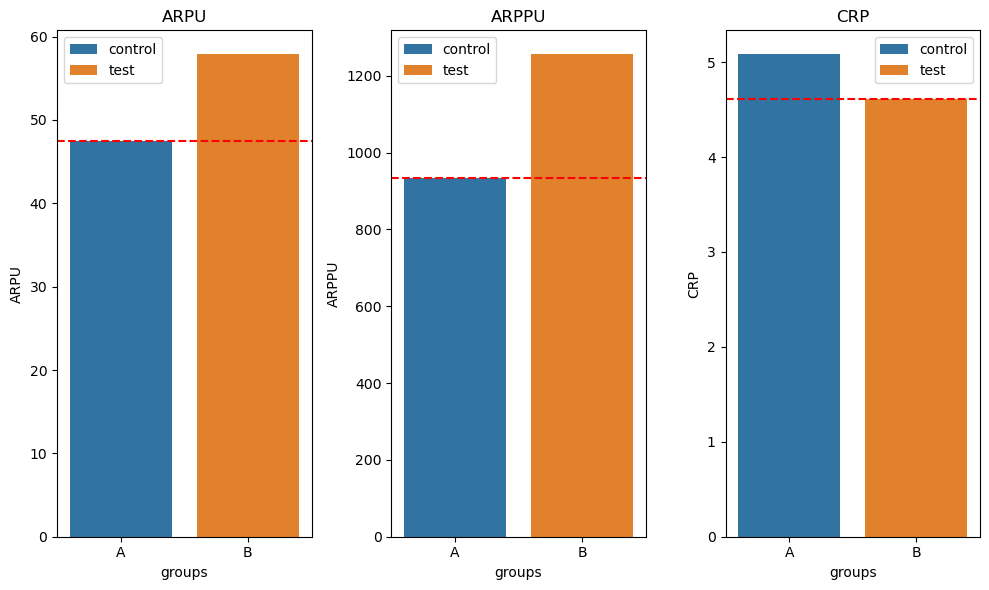

In [37]:
# Создаем фигуру и оси для подграфиков
fig, axes = plt.subplots(1, 3, figsize=(10, 6))
# Строим барплот для метрики ARPU
sns.barplot(ax=axes[0], data=metrics, x='group', y='ARPU',  hue=['control', 'test'])
axes[0].axhline(y=ARPU_A, color='r', linestyle='--')
axes[0].set_xlabel('groups')  # Устанавливаем подпись для оси X
axes[0].set_title('ARPU')  # Добавляем заголовок для тестовой группы

# Строим барплот для метрики ARPPU
sns.barplot(ax=axes[1], data=metrics, x='group', y='ARPPU', hue=['control', 'test'])
axes[1].axhline(y=ARPPU_A, color='r', linestyle='--')
axes[1].set_xlabel('groups')  # Устанавливаем подпись для оси X
axes[1].set_title('ARPPU')  # Добавляем заголовок для контрольной группы

# Строим барплот для метрики CRP
sns.barplot(ax=axes[2], data=metrics, x='group', y='CRP', hue=['control', 'test'])
axes[2].axhline(y=CRP_B, color='r', linestyle='--')
axes[2].set_xlabel('groups')  # Устанавливаем подпись для оси X
axes[2].set_title('CRP')  # Добавляем заголовок для тестовой группы

# Показываем график
plt.tight_layout()  # Автоматически подгоняет подграфики
plt.show()

По предварительным расчётам мы видим , что в тестовой группе увеличилась **ARPU** на **21.96%**, **ARPPU** на **34.52%**, а вот конверсия в платящего студента снизилась примерно на **0.5%**! Теперь необходимо узнать статистически значимы ли эти различия! Так как мы знаем , что студенты совершали только по одной оплате , фактически **ARPPU** является **средним чеком**. Тогда нашими целевыми метриками для оценки результатов АB- теста будут метрики **ARPPU**,  **ARPU** и **CRP**!

### Теперь необходимо узнать статистически значимы ли эти различия!

**Так как мы имеем дело с денежной метрикой, то понимаем что ARPPU и ARPU распределены ненормально (скорее всего будет достаточно много небольших трат или чеков и мало больших чеков) и использовать проверку на нормальность при помощи теста Шапиро-Уилка, к примеру, будет излишним! И, для того, чтобы определиться с тестом, нам необходима проверка дисперсий в группах! Произведём проверку дисперсий при помощи теста Левена!**

Сформулируем нулевую и альтернативную гипотезы:

H0 - дисперсии в контрольной и тестовой группах **ARPPU** и **ARPU** равны (гомоскедаксичность).

H1 - дисперсии в контрольной и тестовой группах **ARPPU** и **ARPU** отличаются (гетероскедаксичность).

In [38]:
# Проверяем гомогенность дисперсий в контрольной и тестовой группах ARPPU
resalt_levene_ARPPU = stats.levene(ARPPU_control, ARPPU_test)
resalt_levene_ARPPU.pvalue

0.08123512497403333

In [39]:
# Проверяем гомогенность дисперсий в контрольной и тестовой группах ARPU
resalt_levene_ARPU = stats.levene(ARPU_control, ARPU_test)
resalt_levene_ARPU.pvalue

0.23288011574035025

Посмотрим на распределения **ARPPU** в контрольной и тестовой группах!

<Axes: xlabel='revenue', ylabel='Count'>

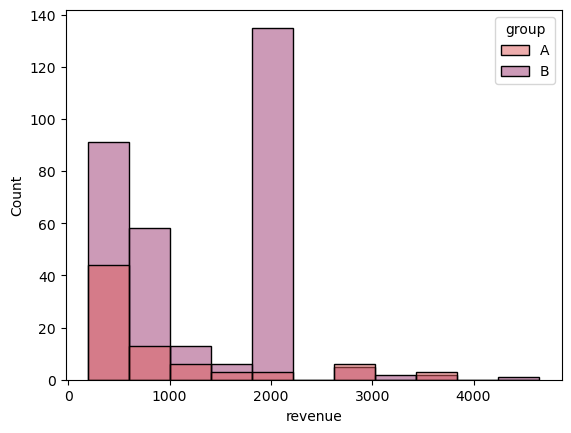

In [40]:
sns.histplot(active_users_and_checks.query('revenue != 0'), x='revenue', hue='group', palette='flare')

Посмотрим на распределения **ARPU** в контрольной и тестовой группах!

<Axes: xlabel='revenue', ylabel='Count'>

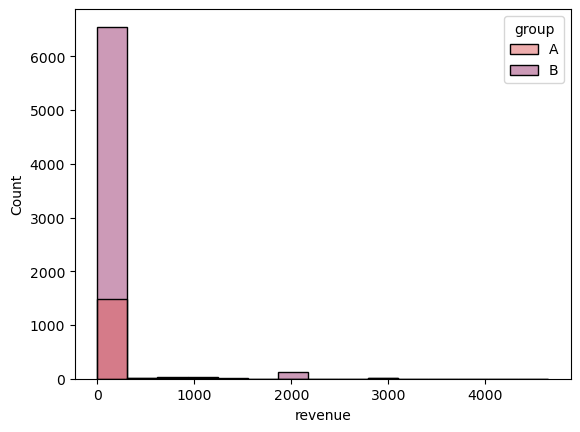

In [41]:
sns.histplot(active_users_and_checks, x='revenue', hue='group', palette='flare')

**Проверим статистическую значимость изменений в метрике ARPPU!**

Сформулируем нулевую и альтернативную гипотезы:

H0 - cтатистически значимых различий **ARPPU** в контрольной и тестовой группах нет.

H1 - ARPPU в тестовой группе статистически значимо увеличилось по сравнению с **ARPPU** в контрольной группе.

Так как тест Левена по **ARPPU** показал p-value = 0.23, у нас недостаточно оснований для того, что отклонить нулевую гипотезу и мы мжем говорить что дисперсии в контрольной и тестовой группах **ARPPU** статистически значимо не отличаются! А так как наши выборки ARPPU_control и ARPPU_test довольно велики (> 30), мы можем не обращать внимания на ненормальность распределения выборок и применить для оценки статистической значимости в изменениях **ARPPU** классический ттест!

In [42]:
resalt_ARPPU = stats.ttest_ind(ARPPU_control, ARPPU_test)
resalt_ARPPU.pvalue

0.001999178560469943

Мы получили p-value < 0.05 (0.019), что говорит нам о том, что у нас достаточно оcнований чтобы отвергнуть нулевую гипотезу и различия в тестовой и контрольной группе **ARPPU** статистически значимы!

**Теперь проверим статистическую значимость изменений в метрике ARPU!**

Сформулируем нулевую и альтернативную гипотезы:

H0 - cтатистически значимых различий **ARPU** в контрольной и тестовой группах нет.

H1 - ARPU в тестовой группе статистически значимо увеличилось по сравнению с **ARPU** в контрольной группе.

Так как тест Левена по **ARPU** показал p-value = 0.23, у нас недостаточно оснований для того, что отклонить нулевую гипотезу и мы мжем говорить что дисперсии в контрольной и тестовой группах **ARPU** статистически значимо не отличаются! А так как наши выборки ARPU_control и ARPU_test измеряются тысячами (1535 и 6793 соответственно), мы можем не обращать внимания на нормальность распределения выборок и применить для оценки статистической значимости в изменениях **ARPU** классический ттест!

In [43]:
resalt_ARPU = stats.ttest_ind(ARPU_control, ARPU_test)
resalt_ARPU.pvalue

0.23288011573839099

Мы получили p-value > 0.05 (0.233), что говорит нам о том, что у нас недостаточно оcнований чтобы отвергнуть нулевую гипотезу и различия в тестовой и контрольной группе **ARPU** не статистически значимы!

**Теперь проверим статистическую значимость изменений в метрике CRP!**

**Так как метрика CRP в тестовой группе уменьшилась, нам она не так интересна с точки зрения принятия решения о выкатывании новой механики оплаты на сайте , но мы проверим стат значимы ли различия в конверсиях в оплату!**

Сформулируем нулевую и альтернативную гипотезы:

H0 - cтатистически значимых различий **CRP** в контрольной и тестовой группах нет.

H1 - CRP в тестовой группе статистически значимо уменьшилось по сравнению с **CRP** в контрольной группе.

In [44]:
# Соберём датафрейм со всеми юзерами, поучавствовавшими в эксперименте и пометим "плативших" и "не плативших"
active_users_and_checks_2 = active_users_and_checks.copy()
active_users_and_checks_2['revenue'] = active_users_and_checks_2['revenue'].apply(lambda x: 'no pay' if x == 0 else 'pay')

In [45]:
# Постороим таблицу сопряженности для оценки конверсий в оплату для контрольной и тестовой групп
pd.crosstab(active_users_and_checks_2.group, active_users_and_checks_2.revenue)

revenue,no pay,pay
group,,
A,1457,78
B,6480,313


In [46]:
# Применим критерий хи - квадрат для оценки изменения конверсий
chi2, p, dof, expected = chi2_contingency(pd.crosstab(active_users_and_checks_2.group, active_users_and_checks_2.revenue))
p

0.46803677583199144

P-value = 0.46 говорит нам о том , что у нас недостаточно оснований для того, чтобы отвергнуть нулевую гипотезу и статистически значимых различий в конверсии в оплату между контрольной и тестовой группой нет!

### Выводы:

 **В результате AB - теста мы получили статистически значимые различия по ARPPU и не стат значимые различия по ARPU, а это означает что мы можем отклонить 0-ю гипотезу о равенстве ARPPU пользователей и не можем отклонить 0-ю гипотезу о равенстве ARPU! Также получили p-value = 0.46 (хи -квадрат), что говорит нам о том, что у нас не достаточно оснований , для того чтобы отклонить нулевую гипотезу о равенстве конверсий в оплату! Разница в контрольной и тестовой группе по ARPPU статистически значимая, в то время как статистически значимой разницы в ARPU и конверсии в оплату нет! Это нам может говорить о том, что новая механика оплаты не влияет на коверсию в оплату, но влияет на уже платящих юзеров, ARPPU которых увеличился!
 Важное замечание в том, что , судя по всему, у нас некорректно работает система сплитования , т к выборки в контроле и тесте получились очень скошенные, а значит и тест был проведён не совсем корректно! Но имеем что имеем в данной ситуации и я бы делал основные выводы после корректировки системы сплитования, а на данный момент принял бы решение на основе стат значимых изменений ARPPU, т е выкатывал бы изменения в механике оплаты на сайте в прод, возможно не на весь пулл юзеров, а на какую то часть, из за сомнений в системе сплитования!**

### Функция по добавлению данных

Реализуем функцию, которая будет принимать на вход название файла с обновлением списка студентов, а на выходе будет возвращать обновленные метрики (**ARPU**, **ARPPU**, **CRP**).

In [50]:
group_add_url = 'https://drive.google.com/file/d/1-NLwzq1uL1TJY8mzxDAJc4FUyiMZkkww/view?usp=sharing'

In [51]:
def upd_metrics_function(group_add_url):
    # Извлекаем ID файла из ссылки
    file_id = group_add_url.split('/d/')[1].split('/')[0]
    # Формируем ссылку на скачивание
    download_url = f'https://drive.google.com/uc?id={file_id}'
    # Отправляем запрос на данные
    response = requests.get(download_url)
    # Проверяем статус ответа
    if response.status_code == 200:
        # Читаем скачанный файл с выбранным разделителем
        group_add = pd.read_csv(StringIO(response.text), sep=',')
    else:
        print(f"Ошибка при скачивании файла: {response.status_code} - {response.text}")
        
    # Так как у нас в условии сказано что названия колонок могут не совпадать, а колонок мы знаем что 2, преобразуем
    # наш датафрейм для общего случая с различающимися названиями колонок
    for i in range(2):
        group_ = list(group_add.iloc[:, i].unique())[i]
        if group_ == 'A' or group_ == 'B':
            group_add['group'] = group_add.iloc[:, i]
        else:
            group_add['student_id'] = group_add.iloc[:, i]

    # Оставим только нужные нам колонки
    group_add = group_add[['student_id', 'group']] 
    # Приведём к нужному типа данных колонку student_id для общего случая
    group_add['student_id'] = group_add['student_id'].astype(str)

    # Обновим датафрейм groups с учётом новых данных о студентах
    groups_upd = pd.concat([groups, group_add], ignore_index=True)
    
    # Соберём датафрейм active_users_and_checks_upd с платящими и не платящими студентами, поучавствовавшими в эксперименте, 
    # с разбивкой по группам, для пересчёта метрик!
    active_users_and_checks_upd = active_studs.merge(checks, on='student_id', how = 'left').merge(groups_upd, on='student_id')
    active_users_and_checks_upd['revenue'] = active_users_and_checks_upd['revenue'].round(2)
    active_users_and_checks_upd['revenue'] = active_users_and_checks_upd['revenue'].fillna(0) # Пропуски в оплатах заполним 0-ми

    # Сформируем отдельно контрольную и тестовую группы
    group_A_upd = active_users_and_checks_upd.query('group == "A" and revenue != 0')
    group_B_upd = active_users_and_checks_upd.query('group == "B" and revenue != 0')

    active_users_group_A_upd = active_users_and_checks_upd.query('group == "A"').shape
    active_users_group_B_upd = active_users_and_checks_upd.query('group == "B"').shape

    control_group_upd = group_A_upd.revenue
    test_group_upd = group_B_upd.revenue

    metrics_upd = pd.DataFrame(data = {'group': ['A', 'B'], 'ARPU': [(control_group_upd.sum() / active_users_group_A_upd[0]).round(2), (test_group_upd.sum() / active_users_group_B_upd[0]).round(2)], 'ARPPU': [control_group_upd.mean().round(2), test_group_upd.mean().round(2)], 'CRP': [control_group_upd.shape[0] * 100 / active_users_group_A_upd[0], test_group_upd.shape[0] * 100 / active_users_group_B_upd[0]]})

    return metrics_upd

In [52]:
# Вызовем функуию upd_metrics_function , подав на вход название файла с обновлением списка студентов
upd_metrics = upd_metrics_function(group_add_url)

In [53]:
upd_metrics

,group,ARPU,ARPPU,CRP
0,A,47.35,933.59,5.071521
1,B,58.06,1257.88,4.615611


### Функция по визуализации метрик

Реализуем функцию, которая на вход будет принимать датафрейм с обновленными метрики, а на выходе будет возвращать визуализацию этих метрик с разбивкой по группам для сравнения.

In [54]:
def vizualization_metrics_function(metrics_sheet):
    # Создаем фигуру и оси для подграфиков
    fig, axes = plt.subplots(1, 3, figsize=(10, 6))

    # Строим барплот для метрики ARPU
    sns.barplot(ax=axes[0], data=metrics_sheet, x='group', y='ARPU',hue=['control', 'test'])
    axes[0].axhline(y=ARPU_A, color='r', linestyle='--')
    axes[0].set_xlabel('groups')  # Устанавливаем подпись для оси X
    axes[0].set_title('ARPU')  # Добавляем заголовок для тестовой группы

    # Строим барплот для метрики ARPPU
    sns.barplot(ax=axes[1], data=metrics_sheet, x='group', y='ARPPU', hue=['control', 'test'])
    axes[1].axhline(y=ARPPU_A, color='r', linestyle='--')
    axes[1].set_xlabel('groups')  # Устанавливаем подпись для оси X
    axes[1].set_title('ARPPU')  # Добавляем заголовок для контрольной группы

    # Строим барплот для метрики CRP
    sns.barplot(ax=axes[2], data=metrics_sheet, x='group', y='CRP', hue=['control', 'test'])
    axes[2].axhline(y=CRP_B, color='r', linestyle='--')
    axes[2].set_xlabel('groups')  # Устанавливаем подпись для оси X
    axes[2].set_title('CRP')  # Добавляем заголовок для тестовой группы

    # Показываем график
    plt.tight_layout()  # Автоматически подгоняет подграфики
    plt.show()

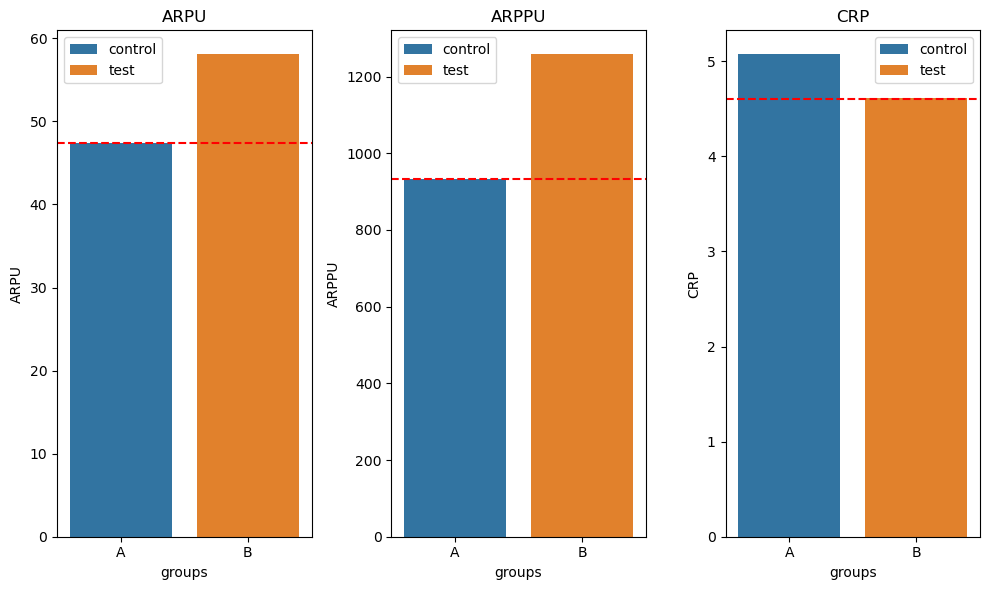

In [55]:
# Вызовем функцию vizualization_metrics_function, чтобы визуализировать обновленные метрики
vizualization_metrics_function(upd_metrics)